# Movie Recommender System Using Surprise Library

<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/divensambhwani/MovieLens-100K_Recommender-System/blob/master/MovieLens-100K-Recommeder%20System-SVD.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/divensambhwani/MovieLens-100K_Recommender-System/blob/master/MovieLens-100K-Recommeder%20System-SVD.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
 </table>



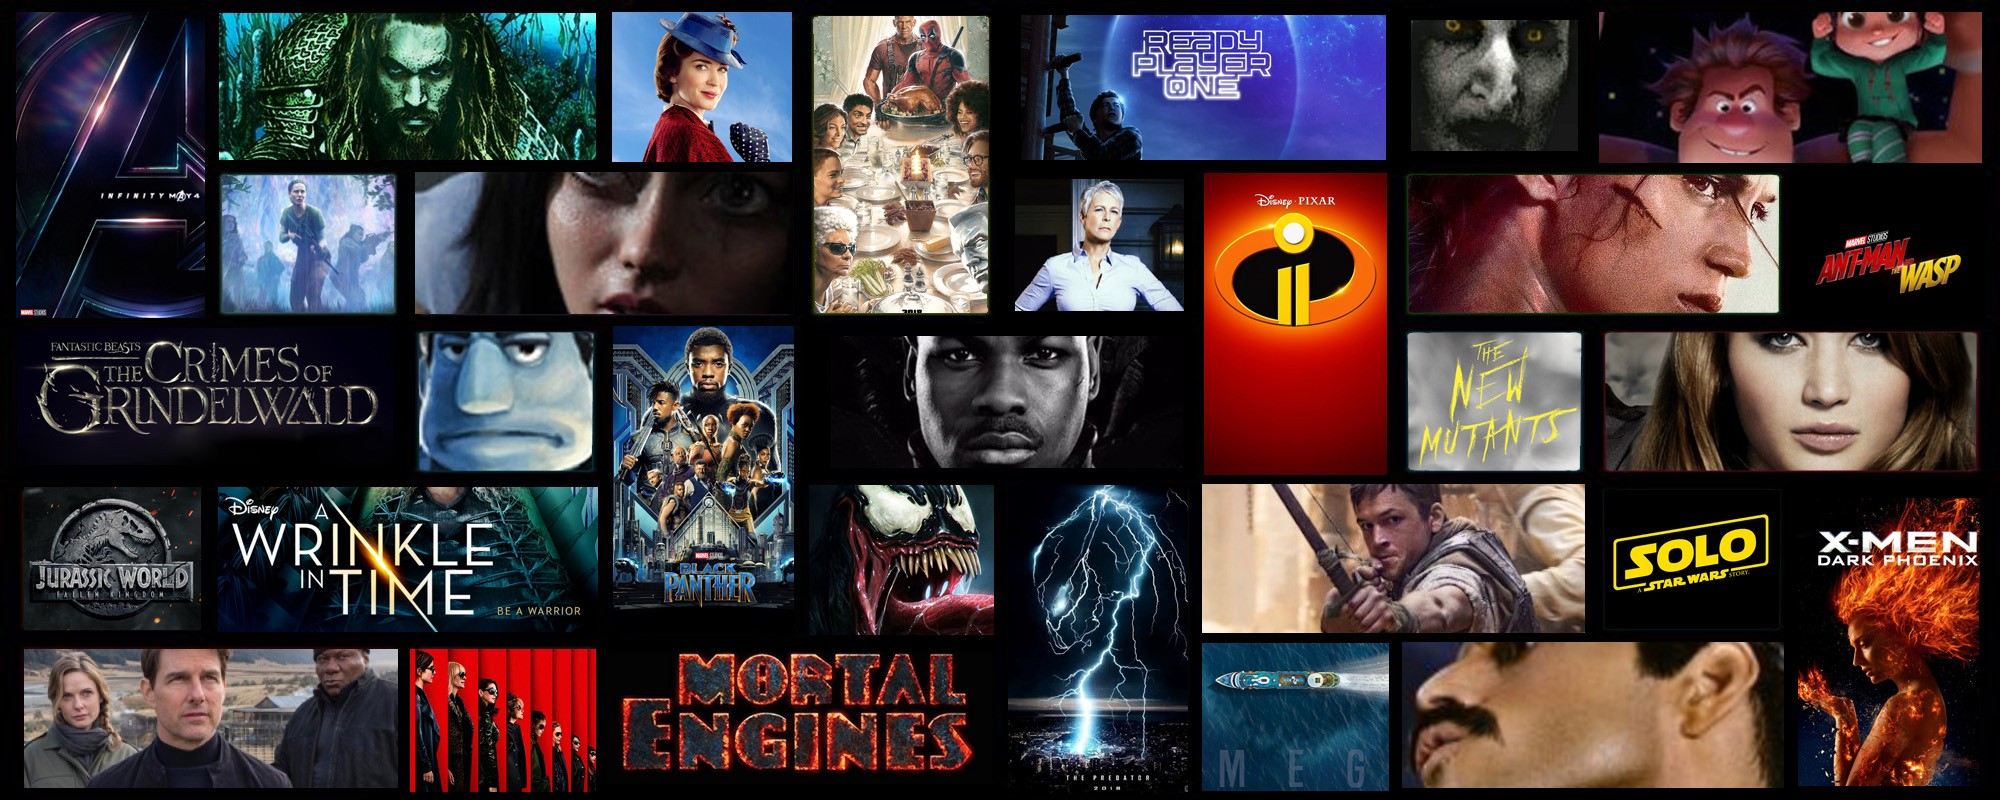

# **Introduction** 


## **Why do we need recommender systems?**
All entertainment websites or online stores have millions/billions of items. It becomes challenging for the customer to select the right one.
At this place, recommender systems come into the picture and help the user to find the right item by minimizing the options.


## **What are recommender systems?**
It helps the user to select the right item by suggesting a presumable list of items and so it has become an integral part of e-commerce, movie and music rendering sites and the list goes on.
They are becoming one of the most popular applications of machine learning which has gained importance in recent years.
The two most popular ways it can be approached/built are:

1- Content-based recommendations (link).

2- Collaborative FIltering (link).


In this post, we will be focussing on the Collaborative filtering method that is: *the user is recommended items that people with similar tastes and preferences liked in the past.*


We will be working with MoiveLens Dataset, a movie rating dataset, to develop a recommendation system using the surprise library. Let's get started!



# Loading Required Libraries

In [1]:
!pip install surprise
import os
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

     |████████████████████████████████| 6.5MB 5.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678069 sha256=d6ece7d5ddfe4b68465b3da9dca0838632680699c26296771dfd1000623a0214
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


# **THE DATA**

In [2]:
# Download the class repository
! git clone https://github.com/divensambhwani/MovieLens-100K_Recommender-System.git  > /dev/null 2>&1
% cd MovieLens-100K_Recommender-System



/content/MovieLens-100K_Recommender-System


In [ ]:
# Nomainīts uz autora path
ratings = pd.read_csv(r"C:\Bakalaurs_praktiskais\Bakalaura-darbs\ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.shape

(100836, 3)

To load a data set from the above pandas data frame, we will use the **load_from_df()** method, we will also need a **Reader object**, and the **rating_scale** parameter must be specified. 

The data frame must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. 

In [0]:
# Define the format
reader = Reader(line_format='user item rating timestamp', sep='\t')

reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# Split data into 5 folds

#data.split(n_folds=5)

# EDA

### Have to define a function to use plotly 3.X versions 

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

## Ratings Distribution

In [0]:
configure_plotly_browser_state()

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Ratings Distribution By Item

In [0]:
configure_plotly_browser_state()


data = df.groupby('itemID')['rating'].count().clip(upper=50)
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Item (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Item'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [0]:
df.groupby('itemID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,itemID,rating
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278
224,260,251
418,480,238
97,110,237
507,589,224
461,527,220


### Ratings Distribution By User


In [0]:
configure_plotly_browser_state()

data = df.groupby('userID')['rating'].count().clip(upper=80)
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [0]:
df.groupby('userID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userID,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
609,610,1302
67,68,1260
379,380,1218
605,606,1115
287,288,1055


The minimumn number of ratings given by a user is 20, where as the most productive user is user-414 giving 2698 rating.
The data is properly distributed and the big chunk of ratings is between 3 and 5 which means people are not very hard towards rating

# Surprise - Model Selection


Surprise is a Python scikit building and analyzing recommender systems that deal with explicit rating data.
Maintained by **Nicolas Hug.**

http://surpriselib.com/

With pip (you’ll need numpy, and a C compiler. Windows users might prefer using conda):


In [0]:
!pip install numpy
!pip install scikit-surprise



With conda:


In [0]:
conda install -c conda-forge scikit-surprise

Here are the average RMSE, MAE and total execution time of various algorithms **(with their default parameters)** on a **3-fold** cross-validation procedure.

<font color=red> We will use __RMSE__ as our accuracy metric for the predictions. </font>


We will be comparing **SVD, NMF, Normal Predictor, KNN Basic** and will be using the one which will have least RMSE value.

Some understanding on the algorithms before we start applying.

**1: Normal Predictor:** It predicts a random rating based on the distribution of the training set, which is assumed to be normal.
It's a basic algorithm that does not do much work but that is still useful for comparing accuracies.

**2: SVD:** It got popularized by Simon Funk during the Netflix prize and is a Matrix Factorized algorithm. If baselines are not used, it is equivalent to PMF.

**3: NMF:** It is based on Non-negative matrix factorization and is similar to SVD.

**4: KNN Basic:** This is a basic collaborative filtering algorithm method.


In [7]:
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

                     
                                        

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [0]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.880859,3.576100,0.218587
NMF,0.934860,4.151578,0.238815
KNNBasic,0.956159,0.073185,1.810942
NormalPredictor,1.425420,0.083729,0.205955


# Tunining algorithm parameters with <font color = red> GridSearchCV </font> to find the best parameters for the algorithm.

**Default values for svd( ):**

**n_factors**  - 100   
**n_epochs**  - 20   
**lr_all**  – 0.005   
**reg_all**   – 0.02 

In [8]:
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#Assigning values
t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

0.8682637035412882
{'n_factors': 35, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}


# Training and Testing 

We use the **train_test_split()** to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. 

We’ll then use the **fit()** method which will train the algorithm on the trainset, and the **test()** method which will return the predictions made from the testset

In [84]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8662


0.8662069886799822

#### Let's check how good or bad our predictions are:
The following function will create a pandas data frame which will consist of these columns:

**UID:** user-id

**iid:** item id

**Rui:** the rating given by the user

**est:** rating estimated by the model

**Iu:** No of items rated by the user

**UI:** number of users that have rated this item

**err:** abs difference between predicted rating and the actual rating.


In [0]:
def get_Iu(uid):
    """ 
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ 
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

In [11]:
df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,305,1259,4.5,4.310286,{'was_impossible': False},507,65,0.189714
1,359,2701,3.0,2.399253,{'was_impossible': False},52,34,0.600747
2,445,7361,4.0,4.029615,{'was_impossible': False},61,104,0.029615
3,249,1833,3.5,3.218637,{'was_impossible': False},796,10,0.281363
4,606,50068,4.0,3.625794,{'was_impossible': False},853,13,0.374206


### Let's see the 10 best and worst predictions our model made

In [0]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [0]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
7323,53,3100,5.0,5.000000,{'was_impossible': False},12,18,0.000000e+00
10073,523,318,5.0,5.000000,{'was_impossible': False},62,220,0.000000e+00
12661,30,260,5.0,5.000000,{'was_impossible': False},25,192,0.000000e+00
12695,171,318,5.0,5.000000,{'was_impossible': False},62,220,0.000000e+00
19687,348,318,5.0,5.000000,{'was_impossible': False},45,220,0.000000e+00
5952,43,356,5.0,5.000000,{'was_impossible': False},85,249,0.000000e+00
14506,171,1104,5.0,5.000000,{'was_impossible': False},62,16,0.000000e+00
24347,543,2959,5.0,5.000000,{'was_impossible': False},61,164,0.000000e+00
13190,30,318,5.0,5.000000,{'was_impossible': False},25,220,0.000000e+00
10857,351,90471,3.5,3.499999,{'was_impossible': False},107,1,6.894915e-07


In [13]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
8350,477,4128,0.5,4.159610,{'was_impossible': False},456,18,3.659610
16615,258,122886,0.5,4.194743,{'was_impossible': False},20,34,3.694743
10607,83,1223,0.5,4.195285,{'was_impossible': False},82,17,3.695285
22616,594,253,0.5,4.253080,{'was_impossible': False},190,77,3.753080
5855,573,8376,0.5,4.310812,{'was_impossible': False},221,29,3.810812
16239,393,5902,0.5,4.331037,{'was_impossible': False},83,33,3.831037
20726,413,1198,1.0,4.862408,{'was_impossible': False},44,157,3.862408
1547,573,44199,0.5,4.430211,{'was_impossible': False},221,28,3.930211
18447,573,3996,0.5,4.483148,{'was_impossible': False},221,80,3.983148
5031,594,2488,0.5,4.626856,{'was_impossible': False},190,1,4.126856


The worst predictions look pretty surprise. Let's look in more details of item "3996",  rated 0.5, our SVD algorithm predicts 4.4


In [15]:
df.loc[df['itemID'] == 3996]['rating'].describe()

count    110.000000
mean       3.836364
std        1.031853
min        0.500000
25%        3.500000
50%        4.000000
75%        4.500000
max        5.000000
Name: rating, dtype: float64

In [21]:
temp = df.loc[df['itemID'] == 3996]['rating']
configure_plotly_browser_state()

# Create trace
trace = go.Histogram(x = temp.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 5, size=.3))
 # Create layout
layout = go.Layout(title = 'Number of ratings item 3996 has received',
                   xaxis = dict(title = 'Number of Ratings Per Item'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

It turns out, most of the ratings this Item received between "3 and 5",only 1% of the users rated "0.5" and one "2.5"below 3. It seems that for each prediction, the users are some kind of outliers and the item has been rated very less number of times.

# **K Recommendations**

## Recall and precision at K
Recall and precision are the classical evaluation metric and are used to evaluate the binary metric and so we have to convert our rating which is scaled from (1-5) into a binary problem relevant and not relevant items.

## Conversion to binary
To do the translation we have to select an arbitrary value on which we can say any rating above that will be considered relevant. There are many methods on selecting that value but for now, we will select 3.5 as the threshold, which means any true rating above 3.5 will be considered relevant and below will be not relevant.

## Deciding 'k'
In recommendation systems, we are interested in showing the top N items to users and so the best is to compute precision and recall on top N values instead of calculating on all the items.


## Definition of Relevant and Recommended
**Relevant:** True Rating > = 3.5

**Irrelevant:** True Rating < 3.5
***
**Recommended item:** Predicted Rating > = 3.5

**Not Recommended item:** Predicted Rating > = 3.5

## Definition of Precision and Recall
**Precision:** It tries to answer "What proportion of positive identifications was actually correct?"
i.e True positive / (True positive+False Positive)
in RecSys we can say (# of recommended items @k that are relevant) / (# of recommended items @k)

**Recall:** It tries to answer "What proportion of actual positives were identified correctly?"
i.e True positive / (True Positive+False Negative)
in RecSys we can say (# of recommended items @k that are relevant) / (# of relevant items @k)


**While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.**

In some circumstances, we might know that we need to maximize either **recall** or **precision** at the cost of the other metric. For example, in disease screening of patients, we would probably want a recall near 1.0 i.e. we want to find all patients who have the disease. 

However, in cases where we want to obtain an optimal blend of precision and recall, we can use **F1** score which is the harmonic mean of precision and recall taking both metrics into account while calculating it.

**f1 score = 2 * (precision * recall) / (precision + recall)**

The below function computes precision and recall and F1 socre as explained above.

In [0]:

#Calculate TP,FP,TN,FN at every threshold level (0.0 - 5.0)

final = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1   

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,25209,0,0,0,1.000000,1.000000,1.000000
1,0.5,25209,0,0,0,1.000000,1.000000,1.000000
2,1.0,24877,331,1,0,0.986869,1.000000,0.993391
3,1.5,24179,1007,9,14,0.960017,0.999421,0.979323
4,2.0,23634,1348,101,126,0.946041,0.994697,0.969759
5,2.5,21316,2709,656,528,0.887242,0.975829,0.929429
6,3.0,18230,2531,2269,2179,0.878089,0.893233,0.885596
7,3.5,10667,2696,7153,4693,0.798249,0.694466,0.742750
8,4.0,3993,820,12343,8053,0.829628,0.331479,0.473694
9,4.5,441,176,19619,4973,0.714749,0.081455,0.146244


As per the results above, the optimal value for threshold is **2.5**.

The next step is to find the optimal K value, and to find it we have to first calculate precision and recall for all the K values(2-10) having threshold value 2.5.

Below is the function to calculate **precision and recall @ K.**

In [0]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls
    
    
###


In [89]:

results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results

###


[{'K': 2, 'Precision': 0.9467213114754098, 'Recall': 0.16936260879485582},
 {'K': 3, 'Precision': 0.9489071038251372, 'Recall': 0.2465311459333644},
 {'K': 4, 'Precision': 0.9439890710382512, 'Recall': 0.31602713167555296},
 {'K': 5, 'Precision': 0.9380054644808752, 'Recall': 0.3770871924196195},
 {'K': 6, 'Precision': 0.9369672131147531, 'Recall': 0.4322470960926637},
 {'K': 7, 'Precision': 0.9344301327088197, 'Recall': 0.4797588761999037},
 {'K': 8, 'Precision': 0.9290729898516782, 'Recall': 0.5160953924681748},
 {'K': 9, 'Precision': 0.9280028623471258, 'Recall': 0.5499734589804299},
 {'K': 10, 'Precision': 0.9277114233671601, 'Recall': 0.5785740629274625}]

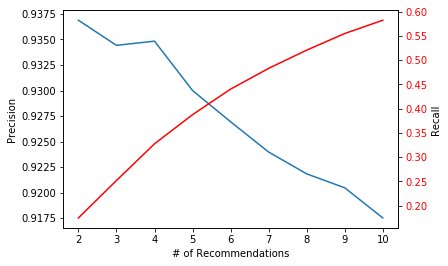

In [24]:
Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')
    ###

As the graph states, Precision drops significantly when K=4

So we will consider the value of K to be 4.

# Time to recommend some movies to users

### Now as we know the optimal number of recommendations to provie, it's time to give recommendations to users. To do so we have to predict ratings for the movies which user has not yet watched.

Here we will be using **build_anti_testset()** method to get the data for testset as we have to predict ratings for the (user, item) pairs which are not present.

In [0]:
#data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

Below is the function to get all the prediction sorted.

In [0]:
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n


In [0]:

all_pred = get_all_predictions(predictions)


#### As we have all the predicted rating, We'll subset to only top **K** movies for every user, where K is 4

In [0]:
#To get top 4 reommendation
n = 4

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]


In [0]:
tmp = pd.DataFrame.from_dict(all_pred)
tmp_transpose = tmp.transpose()


#### Now we have a dataframe which consits of top 4 movies recommended to every user.<br> Let's try one example and find recommendations for user 67

In [0]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

In [74]:
user_id=67
results = get_predictions(user_id)
results

0    (3451, 4.467816119312658)
1    (177593, 4.4276449940903)
2    (1104, 4.427454814311576)
3    (6460, 4.405750852030979)
Name: 67, dtype: object

#### Above matrix is showing top "4" recommendations for user 67. (Movie-id,  Predicted-Rating).<br> But we just need the movies not the ratings, so let's extract the movie id's from the result.

In [75]:
recommended_movie_ids=[]
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])

recommended_movie_ids


[3451, 177593, 1104, 6460]

#### Now as we have the movie-id's to be recommended, Let's find out the movie details of those id's by reading the movie data.

In [ ]:
# Nomainīts path
movies = pd.read_csv("C:\Bakalaurs_praktiskais\Bakalaura-darbs\movies.csv")
movies.head()
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
recommended_movies

,movieId,title,genres
841,1104,"Streetcar Named Desire, A (1951)",Drama
2582,3451,Guess Who's Coming to Dinner (1967),Drama
4396,6460,"Trial, The (Procès, Le) (1962)",Drama
9618,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama


Lets check the user history to see wether the given recommendations are similar or not

In [ ]:
# Nomainīts path
ratings = pd.read_csv(r"C:\Bakalaurs_praktiskais\Bakalaura-darbs\ratings.csv")


ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.head()

NameError: name 'pd' is not defined

In [78]:
temp = df[df['userID'] == 67].sort_values("rating", ascending = False)
temp.head()

,itemID,userID,rating
10324,293,67,5.0
10352,8604,67,5.0
10332,1527,67,5.0
10354,27193,67,5.0
10343,4886,67,4.5


In [79]:
temp.shape

(36, 3)

User 67 has rated 36 movies

In [0]:
history_movie_ids = temp['itemID']
user_history = movies[movies['movieId'].isin(history_movie_ids)]


In [81]:
user_history[:n]

,movieId,title,genres
254,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War


####Now we can compare the results with the user history and see how relevant the recommendations are.
####Above is the user history and below the recommended movies

In [82]:
recommended_movies

,movieId,title,genres
841,1104,"Streetcar Named Desire, A (1951)",Drama
2582,3451,Guess Who's Coming to Dinner (1967),Drama
4396,6460,"Trial, The (Procès, Le) (1962)",Drama
9618,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama


As the history of the user tells that the user mostly likes Drama movies and we are recommending all the Drama movies, which means we are recommending the right movies to the user.

### Voila, It's done!!